In [6]:
import os
os.environ['KERAS_BACKEND'] = 'torch'

import keras
import numpy as np

In [7]:
# Initialisation de l'environnement FIDLE
import fidle

run_id, run_dir, datasets_dir = fidle.init('K3MNIST1')

fit_verbosity = 1
fidle.override('fit_verbosity')

<br>**FIDLE - Environment initialization**

Version              : 2.3.2
Run id               : K3MNIST1
Run dir              : ./run/K3MNIST1
Datasets dir         : c:\Users\benja\Desktop\Pro\EFREI\Machine Learning\datasets-fidle
Start time           : 18/12/24 19:37:05
Hostname             : ROG-DB (Windows)
Tensorflow log level : Info + Warning + Error  (=0)
Update keras cache   : False
Update torch cache   : False
Save figs            : ./run/K3MNIST1/figs (False)
keras                : 3.7.0
numpy                : 2.0.2
sklearn              : 1.6.0
yaml                 : 6.0.2
matplotlib           : 3.9.3
pandas               : 2.2.3
torch                : 2.5.1+cpu


In [8]:
# Chargement des données MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

x_train :  (60000, 28, 28)
y_train :  (60000,)
x_test  :  (10000, 28, 28)
y_test  :  (10000,)


In [9]:
# Normalisation des données
print('Before normalization : Min={}, max={}'.format(x_train.min(), x_train.max()))
x_train = x_train / 255.0
x_test = x_test / 255.0
print('After normalization  : Min={}, max={}'.format(x_train.min(), x_train.max()))

Before normalization : Min=0, max=255
After normalization  : Min=0.0, max=1.0


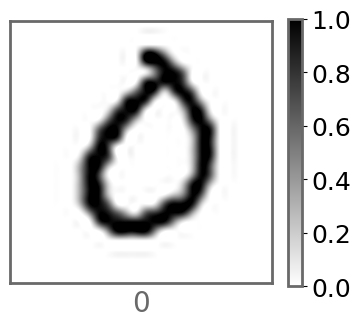

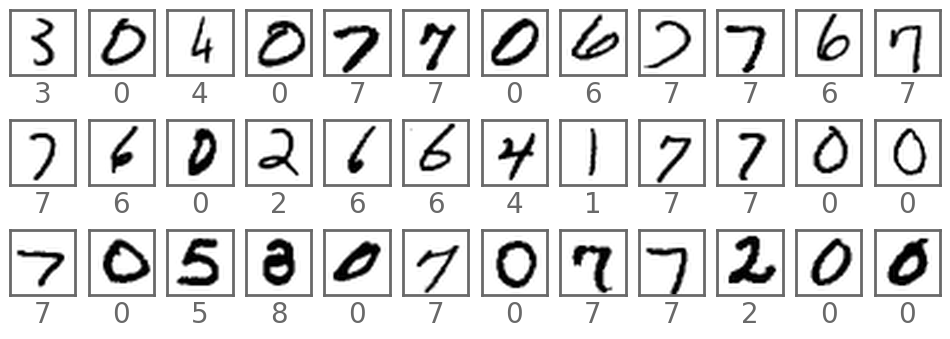

In [10]:
# Étape : Déséquilibre du dataset
def creer_dataset_desequilibre(x, y):
    indices_7 = np.where(y == 7)[0]
    indices_1 = np.where(y == 1)[0]
    indices_0 = np.where(y == 0)[0]
    indices_8 = np.where(y == 8)[0]

    # Augmente les exemples pour 7 et 0, réduire pour 1 et 8
    desequilibre_indices = np.concatenate([
        np.random.choice(indices_7, size=5000, replace=True),  # Beaucoup de 7
        np.random.choice(indices_1, size=500, replace=False),  # Peu de 1
        np.random.choice(indices_0, size=5000, replace=True),  # Beaucoup de 0
        np.random.choice(indices_8, size=500, replace=False)   # Peu de 8
    ])

    # Ajoute des exemples équilibrés pour les autres classes
    autres_classes_indices = np.where((y != 7) & (y != 1) & (y != 0) & (y != 8))[0]
    desequilibre_indices = np.concatenate([
        desequilibre_indices,
        np.random.choice(autres_classes_indices, size=5000, replace=False)
    ])

    np.random.shuffle(desequilibre_indices)
    return x[desequilibre_indices], y[desequilibre_indices]

x_train, y_train = creer_dataset_desequilibre(x_train, y_train)

fidle.scrawler.images(x_train, y_train, [27],  x_size=5,y_size=5, colorbar=True, save_as='01-one-digit')

# Visualisation des données déséquilibrées
fidle.scrawler.images(x_train, y_train, range(5, 41), columns=12, save_as='02-many-digits-desequilibres')

In [11]:
# Modèle : Même structure que précédemment
hidden1 = 100
hidden2 = 100

model = keras.Sequential([
    keras.layers.Input((28, 28)),
    keras.layers.Flatten(),
    keras.layers.Dense(hidden1, activation='relu'),
    keras.layers.Dense(hidden2, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 512
epochs = 16

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=fit_verbosity,
                    validation_data=(x_test, y_test))

Epoch 1/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5114 - loss: 1.5252 - val_accuracy: 0.7161 - val_loss: 0.9724
Epoch 2/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8873 - loss: 0.4253 - val_accuracy: 0.8677 - val_loss: 0.4786
Epoch 3/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9351 - loss: 0.2380 - val_accuracy: 0.8842 - val_loss: 0.4000
Epoch 4/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9466 - loss: 0.1942 - val_accuracy: 0.9076 - val_loss: 0.3249
Epoch 5/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9537 - loss: 0.1617 - val_accuracy: 0.9127 - val_loss: 0.3062
Epoch 6/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9607 - loss: 0.1425 - val_accuracy: 0.9248 - val_loss: 0.2605
Epoch 7/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9659 - loss: 0.1241 - val_accuracy: 0.9262 - val_loss: 0.2601
Epoch 8/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9709 - loss: 0.1075 - val_accuracy: 0.9218 - val_

Test loss     : 0.21482454240322113
Test accuracy : 0.940500020980835


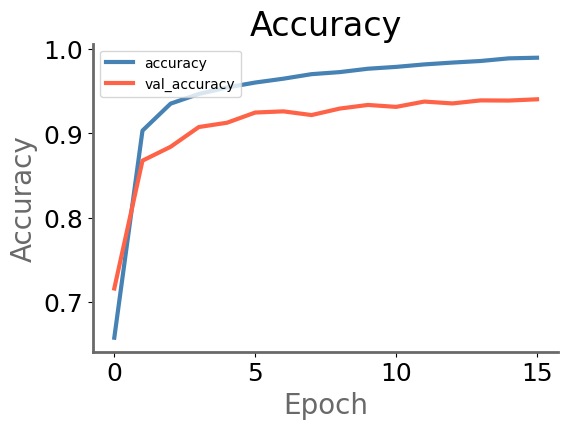

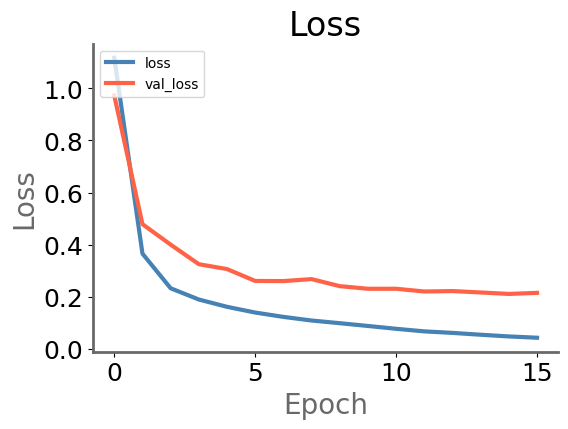

In [12]:
# Évaluation
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss     :', score[0])
print('Test accuracy :', score[1])

fidle.scrawler.history(history, figsize=(6,4), save_as='03-history')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


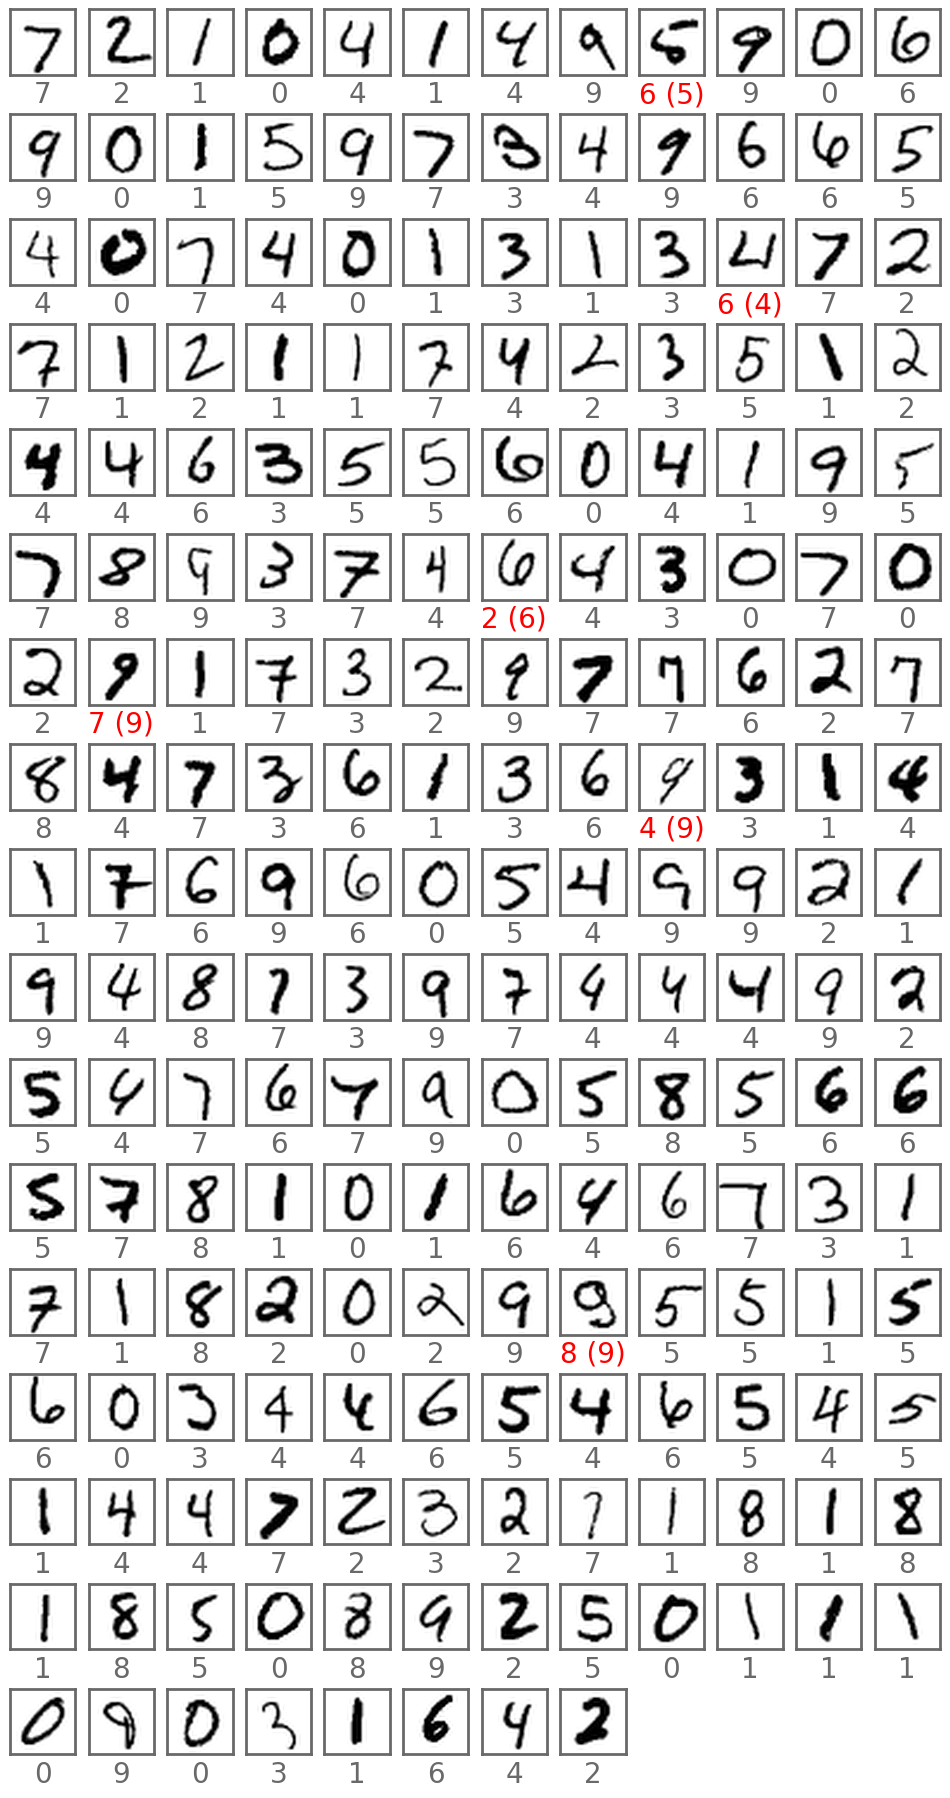

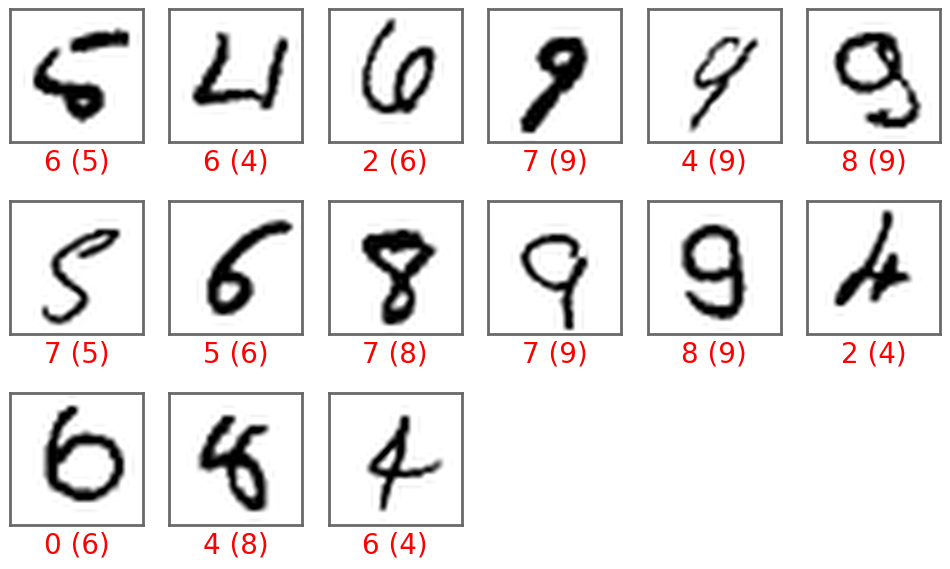

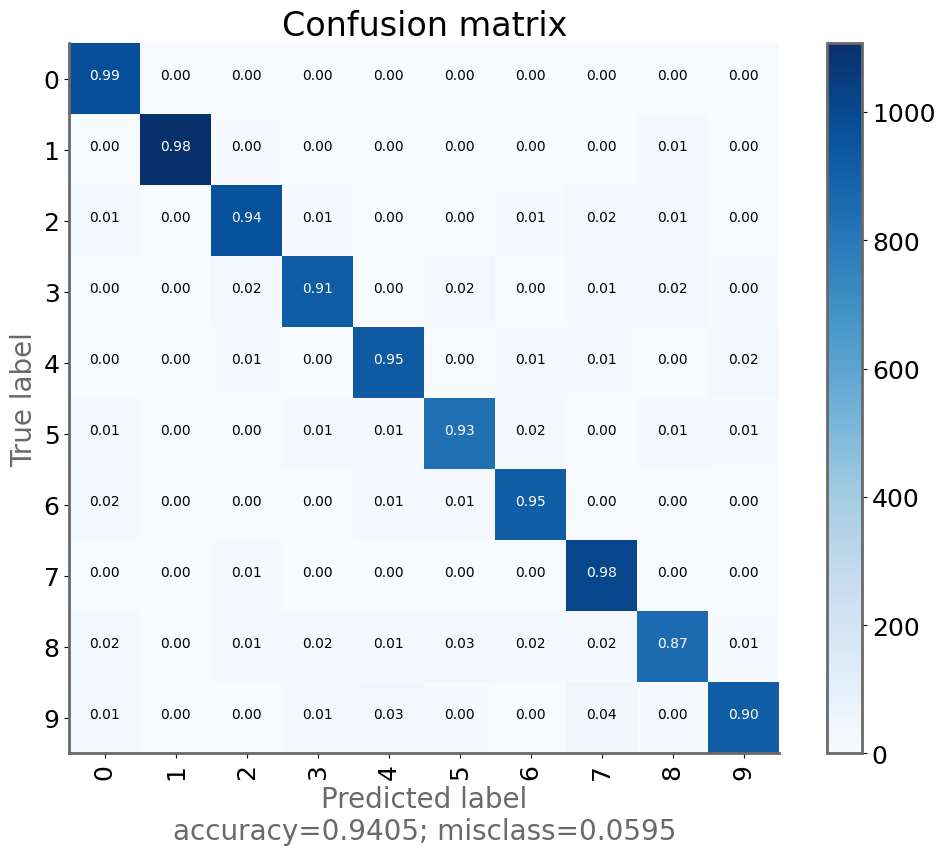

**End time :** 18/12/24 19:37:14  
**Duration :** 00:00:09 335ms  
This notebook ends here :-)  
[https://fidle.cnrs.fr](https://fidle.cnrs.fr)

In [13]:
# Matrice de confusion
y_sigmoid = model.predict(x_test, verbose=fit_verbosity)
y_pred = np.argmax(y_sigmoid, axis=-1)

fidle.scrawler.images(x_test, y_test, range(0,200), columns=12, x_size=1, y_size=1, y_pred=y_pred, save_as='04-predictions')

errors=[ i for i in range(len(x_test)) if y_pred[i]!=y_test[i] ]
errors=errors[:min(24,len(errors))]
fidle.scrawler.images(x_test, y_test, errors[:15], columns=6, x_size=2, y_size=2, y_pred=y_pred, save_as='05-some-errors')

fidle.scrawler.confusion_matrix(y_test, y_pred, range(10), normalize=True, save_as='06-confusion-matrix-desequilibre')

fidle.end()